In [360]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
np.random.seed(1)
np.set_printoptions(suppress=True, precision=6)

In [361]:
N = 6
# Testing vector
X = np.reshape(np.flip(np.arange(3 * N)), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

bars[0,1] = 0.5
bars[1, 2] = 0.5
cables[2,3] = 0.5
bars[3, 4] = 0.5
bars[4,5] = 1

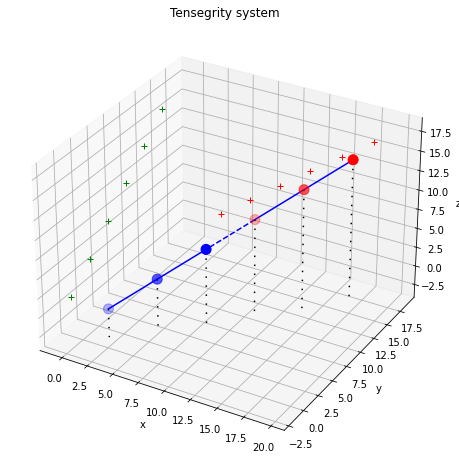

[[-1.75, 20.75], [-2.75, 19.75], [-3.75, 18.75]]

In [362]:
def plot_points(X, bars, cables, M, lims = [None, None, None], title = "Tensegrity system"):
    """ Plotting 3D tensegrity system

    Args:
        X (array(3*N)): array of nodes
        bars (array(N, N)): neighbour array. bars[i, j] = l_ij. if bars[i, j] = 0, then there is no connetion
        cables (array(N, N)): neighbour array. cables[i, j] = l_ij. if cables[i, j] = 0, then there is no connetion
        M (int): number of fixed nodes
        lims (list, optional): . Defaults to [None, None, None].
        title (str, optional): _description_. Defaults to "Tensegrity system".

    Returns:
        list of limits: limits in x, y, and z axis
    """
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(projection = '3d')
    ax.set_title(title)
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    
    xlims, ylims, zlims = lims
    if xlims == None:
        xmin, xmax = np.min(X[:,0]), np.max(X[:,0])
        xlims = [xmin - (xmax-xmin) / 4, xmax + (xmax-xmin) / 4]
    if ylims == None:
        ymin, ymax = np.min(X[:,1]), np.max(X[:,1])
        ylims = [ymin - (ymax-ymin) / 4, ymax + (ymax-ymin) / 4]
    if zlims == None:
        zmin, zmax = np.min(X[:,2]), np.max(X[:,2])
        zlims = [zmin - (zmax-zmin) / 4, zmax + (zmax-zmin) / 4]

    ax.scatter(x[:M], y[:M], z[:M], s = 100, c = 'red')
    ax.scatter(x[M:], y[M:], z[M:], s = 100, c = 'blue')

    ax.plot(x, z, 'r+', zdir='y', zs = ylims[1])    # Projection on xz plane
    ax.plot(y, z, 'g+', zdir='x', zs = xlims[0])    # Projection on yz plane

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim3d(xlims[0], xlims[1])
    ax.set_ylim3d(ylims[0], ylims[1])
    ax.set_zlim3d(zlims[0], zlims[1])

    cable_indices = np.asarray(np.where(cables != 0))
    for i, j in cable_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b--')

    bar_indices = np.asarray(np.where(bars != 0))
    for i, j in bar_indices.T:
        ax.plot([x[i], x[j]], [y[i], y[j]], [z[i], z[j]], 'b-')

    # Projection down on z
    for i in range(len(z)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [z[i], zlims[0]], linestyle = (0, (1, 5)), color = 'black')
    plt.show() 
    return [xlims, ylims, zlims]

plot_points(X, bars, cables, 3)

## Energy functions

In [363]:
def E(X, cables, bars, ms, consts):
    """ Target function

    Args:
        X (array(3*N)): array of nodes
        cables (array(N, N)): neighbour array. cables[i, j] = l_ij. if cables[i, j] = 0, then there is no connetion
        bars (array(N, N)): neighbour array. bars[i, j] = l_ij. if bars[i, j] = 0, then there is no connetion
        ms (array(N)): mass of nodes
        consts (list): constants g, rho, c, and k

    Returns:
        float: energy of system
    """
    g, rho, c, k = consts
    X = X.reshape(len(ms), 3)

    # External load
    E_ext = g * np.sum(ms * X[:, 2])

    # Bars
    bars_indices = np.asarray(np.where(bars != 0))
    grav_bar = 0
    elast_bar = 0
    for i, j in bars_indices.T:
        grav_bar += bars[i, j] * (X[i, 2] + X[j, 2])
        elast_bar += (np.linalg.norm(X[i] - X[j]) - bars[i, j])**2 / bars[i, j]**2
    E_bar = rho * g * grav_bar / 2 + c / 2 *  elast_bar

    # Cables
    cables_indices = np.asarray(np.where(cables != 0))
    elast_cable = 0
    for i, j in cables_indices.T:
        if np.linalg.norm(X[i] - X[j]) > cables[i, j]:
            elast_cable += (np.linalg.norm(X[i] - X[j]) - cables[i, j])**2 / cables[i, j]**2
    E_cable = elast_cable * k / 2
    return E_ext + E_bar + E_cable

# Test
g, rho, c, k = 9.81, 1, 1, 1
consts = [g, rho, c, k]
ms = 0.1 * np.ones(N)
print(E(X, cables, bars, ms, consts))

383.88712819564034


### Derivative of energy functions

In [364]:
def dE(Y, P, cables, bars, ms, N, M, consts):
    """ Gradient of target function

    Args:
        Y (array(3*(N-M))): variable nodes
        P (array(3*M)): fixed nodes
        cables (array(N, N)): neighbour array. cables[i, j] = l_ij. if cables[i, j] = 0, then there is no connetion
        bars (array(N, N)): neighbour array. bars[i, j] = l_ij. if bars[i, j] = 0, then there is no connetion
        ms (array(N)): mass of nodes
        N (int): number of nodes
        M (int): number of fixed nodes
        consts (list): constants g, rho, c, and k

    Returns:
        array(3*(N-M)): gradient of target function
    """
    Y = Y.reshape(N-M, 3)
    g, rho, c, k = consts

    # External loads
    dE_ext = np.zeros((N-M, 3))
    dE_ext[:, 2] = g * ms[M:]

    if M > 0:
        X = np.vstack((P, Y))
    else:
        X = Y

    # Bars
    bars_indices = np.asarray(np.where(bars != 0))
    grav_bar = np.zeros((N, 3))
    elast_bar = np.zeros((N, 3))
    
    for i, j in bars_indices.T:
        norm = np.linalg.norm(X[i] - X[j])
        grav_bar[i] += np.array([0, 0, bars[i, j]])
        grav_bar[j] += np.array([0, 0, bars[i, j]])
        elast_bar[i] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([X[i, 0] - X[j, 0], X[i, 1] - X[j, 1], X[i, 2] - X[j, 2]])
        elast_bar[j] += (norm - bars[i, j]) / (bars[i, j]**2 * norm) * np.array([-X[i, 0] + X[j, 0], -X[i, 1] + X[j, 1], -X[i, 2] + X[j, 2]])
    dE_bar = rho * g * grav_bar[M:] / 2 + c *  elast_bar[M:]

    # Cables
    cable_indices = np.asarray(np.where(cables != 0))
    elast_cable = np.zeros((N, 3))
    
    for i, j in cable_indices.T:
        norm = np.linalg.norm(X[i] - X[j])
        if norm > cables[i, j]:
            elast_cable[i] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([X[i, 0] - X[j, 0], X[i, 1] - X[j, 1], X[i, 2] - X[j, 2]])
            elast_cable[j] += (norm - cables[i, j]) / (cables[i, j]**2 * norm) * np.array([-X[i, 0] + X[j, 0], -X[i, 1] + X[j, 1], -X[i, 2] + X[j, 2]])
    dE_cable = k * elast_cable[M:]

    return (dE_ext + dE_bar + dE_cable).flatten()

M = 1
print(dE(X[M:], X[:M], cables, bars, ms, N, M, consts))

[ 0.       0.       5.886    0.       0.       3.4335   0.       0.
  3.4335  -8.42265 -8.42265 -0.08415 -2.42265 -2.42265  3.46335]


### Backtracking

In [365]:
def line_search(x, p, c1, c2, f, df, maxiter = 100):
    """ Line search using Wolfe conditions

    Args:
        x (array): initial vector
        p (array): search direction
        c1, c2 (ints): backtracking parameters
        f (func): target function
        df (func): gradient of target function
        maxiter (int, optional): maximum number of iterations. Defaults to 100.

    Returns:
        alpha (int): step length
    """
    assert(c1 < c2)
    alpha_min, alpha_max = 0, np.inf
    alpha = 1
    I = f(x + alpha * p) <= f(x) + c1 * alpha * np.inner(df(x), p)                      # Armijo condition
    II = np.abs(np.inner(df(x + alpha * p), p)) <= c2 * np.abs(np.inner(df(x), p))      # Curvature condition
    iter = 0
    while not (I and II):
        if iter > maxiter:
            break
        if not I:
            alpha_max = alpha
            alpha = (alpha_min + alpha_max) / 2
        else:
            alpha_min = alpha
            if alpha_max < np.inf:
                alpha = (alpha_min + alpha_max) / 2
            else:
                alpha *= 2
        I = f(x + alpha * p) <= f(x) + c1 * alpha * np.inner(df(x), p)
        II = np.abs(np.inner(df(x + alpha * p), p)) <= c2 * np.abs(np.inner(df(x), p))
        iter += 1
    return alpha

### Test case

In [366]:
def BFGS(X0, N, M, cables, bars, maxiter, f, df, tol = 1e-6, keep_limits = [False, False, False]):
    """
    BFGS algorithm to find a local minimiser of a tensegrity system, using fixed nodes.

    Args:
        X0 (array(N, 3)): x,y,z coordinates of nodes
        N (int): number of nodes
        M (int): number of fixed nodes
        cables (array(N, N)): neighbour array. cables[i, j] = l_ij. if cables[i, j] = 0, then there is no connetion
        bars (array(N, N)): neighbour array. bars[i, j] = l_ij. if bars[i, j] = 0, then there is no connetion
        maxiter (int): number of iteriations
        f (func): function to minimize
        df (func): gradient of f
        keep_limits (list of bool, optional): Keep limits between plots in x, y, and z axis respectively

    Returns:
        (array(N, 3)): solution
    """
    original_limits = plot_points(X0.reshape((N,3)), bars, cables, M, title = 'Original system')

    P = X0[:3 * M]                      # Fixed nodes
    Y0 = X0[3 * M:]                     # Variable nodes

    c1, c2 = 0.025, 0.2                 # Backtracking parameters

    # First: Gradient descent
    p = -df(Y0)
    alpha = line_search(Y0, p, c1, c2, f, df)
    Y1 = Y0 + alpha * p

    sk = Y1 - Y0
    yk = df(Y1) - df(Y0)
    sk = np.array([sk]).reshape((3*(N-M), 1))
    yk = np.array([yk]).reshape((3*(N-M), 1))
    H = (sk.T @ yk) / (yk.T @ yk) * np.eye(3 * (N - M))

    for k in range(maxiter):
        p = -H @ df(Y1)

        alpha = line_search(Y1, p, c1, c2, f, df)
        Y0 = Y1
        Y1 = Y0 + alpha * p
        
        sk = Y1 - Y0
        yk = df(Y1) - df(Y0)

        sk = np.array([sk]).reshape((3*(N-M), 1))
        yk = np.array([yk]).reshape((3*(N-M), 1))

        Hkyk = H@yk
        Sk = 1 / (yk.T @ sk)
        H = H.copy() - Sk * (sk @ Hkyk.T + Hkyk @ sk.T) + sk @ sk.T * (Sk**2 * Hkyk.T @ yk + Sk)

        if M == 0:              # Fix coordinate system to the first node
            Y1[0::3] -= Y1[0]
            Y1[1::3] -= Y1[1]

        if np.linalg.norm(sk) < tol or np.linalg.norm(yk) < tol:
            print("Converged after", k, "iterations")
            break
    
    for i in range(3):
        if not keep_limits[i]:
            original_limits[i] = None
    
    plot_points((np.concatenate((P, Y1))).reshape(N, 3), bars, cables, M, lims = original_limits)
    return Y1

N = 6
M = 1
X = np.reshape(np.flip(np.arange(3 * N)), (N, 3))
bars = np.zeros((N, N))
cables = np.zeros((N, N))

bars[0,1] = 0.5
bars[1, 2] = 0.5
cables[2,3] = 0.5
bars[3, 4] = 0.5
bars[4,5] = 1

X0 = X.flatten()
P = X0[:3 * M]
Y0 = X0[3 * M:]

def f(Y):
    X = np.concatenate((P, Y))
    return E(X, cables, bars, ms, consts)
def df(Y):
    return dE(Y, P.reshape(M, 3), cables, bars, ms, N, M, consts)

#BFGS(X0, N, M, cables, bars, 100, f, df, keep_limits = True)

## Cable system where solution is known

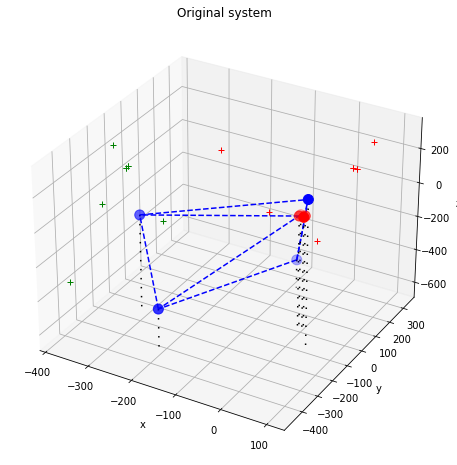

Converged after 26 iterations


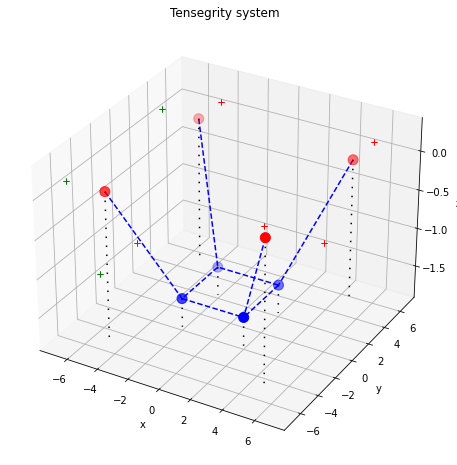

[[ 2.   2.  -1.5]
 [-2.   2.  -1.5]
 [-2.  -2.  -1.5]
 [ 2.  -2.  -1.5]]


In [367]:
g, rho, c, k = 9.81, 1, 1, 3
consts = [g, rho, c, k]
N = 8
M = 4
P = np.array([[5, 5, 0],
              [-5, 5, 0],
              [-5, -5, 0],
              [5, -5, 0]])
Y0 = (np.random.rand(N-M, 3) - 0.5)*1000
X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))
cables[0, 4], cables[1, 5], cables[2, 6], cables[3, 7], cables[4, 5], cables[4, 7], cables[5, 6], cables[6, 7] = [3] * 8

ms = np.ones(N) / (6 * g)

def f(Y):
    X = np.concatenate((P.flatten(), Y))
    return E(X, cables, bars, ms, consts)

def df(Y):
    return dE(Y, P, cables, bars, ms, N, M, consts)

Y = BFGS(X0.flatten(), N, M, cables, bars, 100, f, df)
print(Y.reshape((N-M, 3)))

## Test case with cables and bars

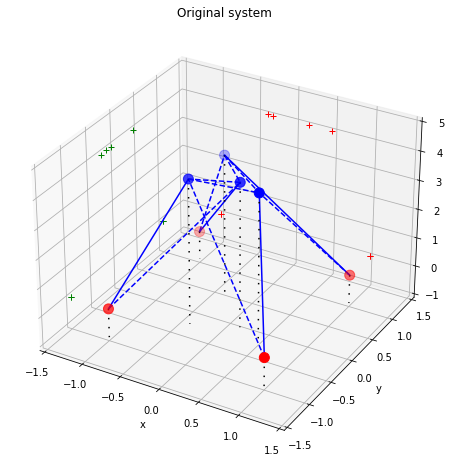

Converged after 79 iterations


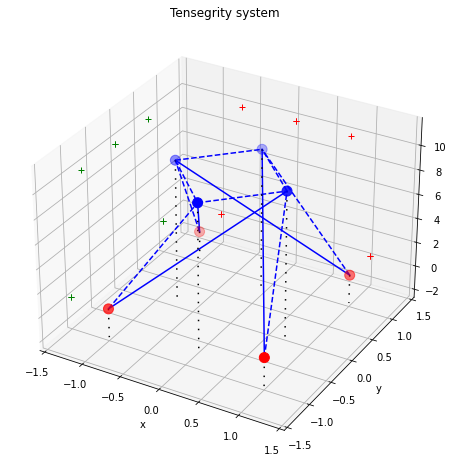

[[-0.7095    0.        9.54    ]
 [-0.000003 -0.7095    9.54    ]
 [ 0.7095    0.        9.54    ]
 [-0.000003  0.7095    9.54    ]]


In [368]:
g, rho, c, k = 0, 0, 1, 0.1
consts = [g, rho, c, k]
N = 8
M = 4
P = np.array([[1, 1, 0],
              [-1, 1, 0],
              [-1, -1, 0],
              [1, -1, 0]])
Y0 = np.random.rand(N-M, 3) - 0.5
Y0[:, 2] = 4
P[0, 2] = 0.5
X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))

bars[0, 4], bars[1, 5], bars[2, 6], bars[3, 7] = [10] * 4
cables[0, 7], cables[1, 4], cables[2, 5], cables[3, 6] = [8] * 4
cables[4, 5], cables[4, 7], cables[5, 6], cables[6, 7] = [1] * 4

ms = np.zeros(N)

def f(y):
    X = np.concatenate((P.flatten(), y))
    return E(X, cables, bars, ms, consts)

def df(y):
    return dE(y, P, cables, bars, ms, N, M, consts)

Y = BFGS(X0.flatten(), N, M, cables, bars, 1000, f, df)

Y = Y.reshape((N-M, 3))
print(np.float16(Y))

s, t = 0.70970, 9.54287
Ystar = np.array([[-s,0,t], 
               [0, -s, t],
               [s,0,t],
               [0,s,t]])


### Tensegrity table

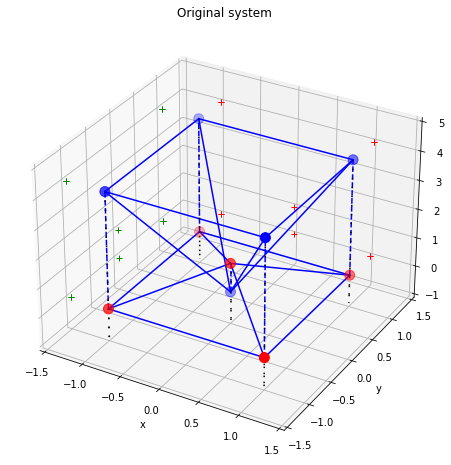

Converged after 26 iterations


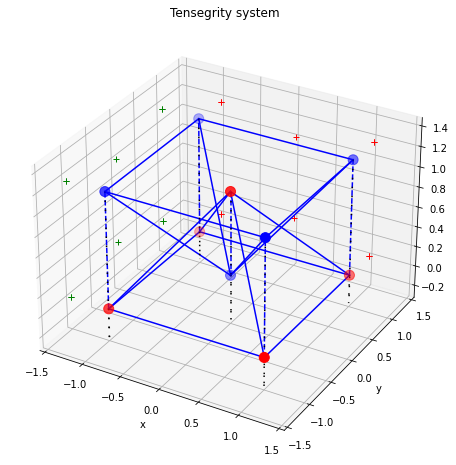

In [369]:
g, rho, c, k = 9.81, 0, 10, 10
consts = [g, rho, c, k]
N = 10
M = 5
P = np.array([[1, 1, 0],
              [-1, 1, 0],
              [-1, -1, 0],
              [1, -1, 0],
              [0, 0, 1]])
Y0 = np.random.rand(N-M, 3) - 0.5
Y0 = np.copy(P)
Y0[:, 2] += 4
Y0[-1, 2] = np.sqrt(2) - 1

X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))

bars[0, 1], bars[1, 2], bars[2, 3], bars[0, 3] = [2] * 4
bars[0, 4], bars[1, 4], bars[2, 4], bars[3, 4] = [np.sqrt(3)] * 4

bars[5, 6], bars[6, 7], bars[7, 8], bars[5, 8] = [2] * 4
bars[5, 9], bars[6, 9], bars[7, 9], bars[8, 9] = [np.sqrt(3)] * 4

cables[0, 5], cables[1, 6], cables[2, 7], cables[3, 8] = [2] * 4
cables[4, 9] = 2*np.sqrt(2) - 2

ms = 0.001 * np.ones(N)

def f(y):
    X = np.concatenate((P.flatten(), y))
    return E(X, cables, bars, ms, consts)

def df(y):
    return dE(y, P, cables, bars, ms, N, M, consts)

Y = BFGS(X0.flatten(), N, M, cables, bars, 100, f, df)
Y = Y.reshape((N-M, 3))

## With ground- Logarithmic barriers

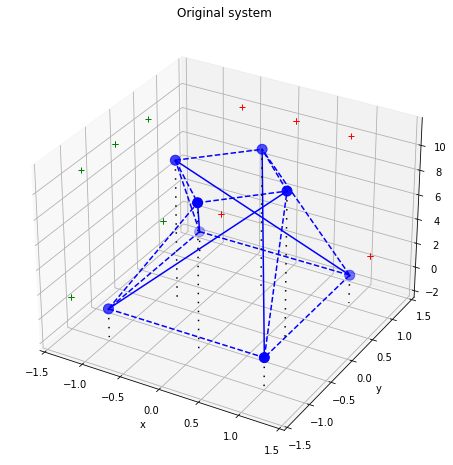

Converged after 44 iterations


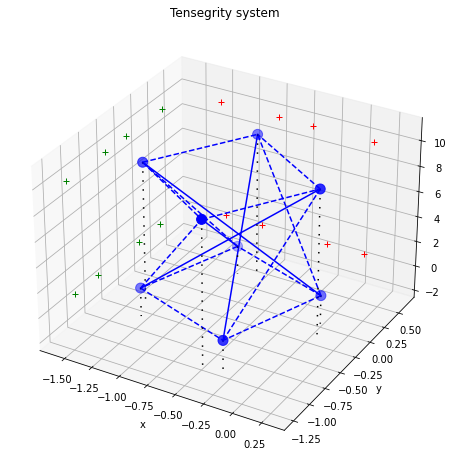

[[ 0.        0.        0.000001]
 [-0.948383  0.337851 -0.      ]
 [-1.286234 -0.610533  0.000009]
 [-0.337851 -0.948383 -0.000001]
 [-1.338085 -0.459579  9.191531]
 [-0.488804 -1.000235  9.191531]
 [ 0.051851 -0.150954  9.191531]
 [-0.79743   0.389702  9.191531]]


In [375]:
def cmin(X):        # c^- function as defined
    Y = X.copy()
    Y[Y > 0] = 0
    return Y

def Q(X, mu, cables, bars, ms, consts):
    return E(X, cables, bars, ms, consts) + 1/2 * mu * np.sum(cmin(X[2::3])**2)

def dQ(X, mu, cables, bars, ms, consts):
    barrier = np.zeros(X.shape).flatten()
    barrier[2::3] = mu * cmin(X[2::3])
    return dE(X, np.array([]), cables, bars, ms, N, 0, consts) + barrier

g, rho, c, k = 0.01, 0.1, 1, 0.1
consts = [g, rho, c, k]
N = 8
M = 0
P = np.array([[1, 1, 0.1],
              [-1, 1, 0.1],
              [-1, -1, 0.1],
              [1, -1, 0.1]])
Y0 = P.copy()
Y0[:, 2] += 4
Y0[:, 0:1] *= 0.5
Y0 = Ystar
#Y0 = np.roll(Y0, -1, axis = 0)
#Y0 = np.flip(Y0, axis = 0)
#P[0, 2] = 0.5

X0 = np.vstack((P, Y0))

cables = np.zeros((N, N))
bars = np.zeros((N, N))

cables[0, 1], cables[1, 2], cables[2, 3], cables[0, 3] = [1] * 4
bars[0, 4], bars[1, 5], bars[2, 6], bars[3, 7] = [10] * 4
cables[0, 7], cables[1, 4], cables[2, 5], cables[3, 6] = [8] * 4
cables[4, 5], cables[4, 7], cables[5, 6], cables[6, 7] = [1] * 4

ms = np.zeros(N) * 0.001

mu = 10000
#print(Q(X0.flatten(), mu, cables, bars, ms, consts))
#print(dQ(X0.flatten(), mu, cables, bars, ms, consts))

def f(X):
    return Q(X, mu, cables, bars, ms, consts)

def df(X):
    return dQ(X, mu, cables, bars, ms, consts)

Y = BFGS(X0.flatten(), N, 0, cables, bars, 1000, f, df, tol = 1e-6)
print(Y.reshape(N, 3))

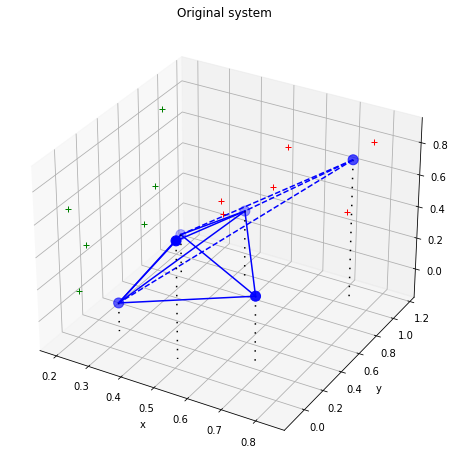

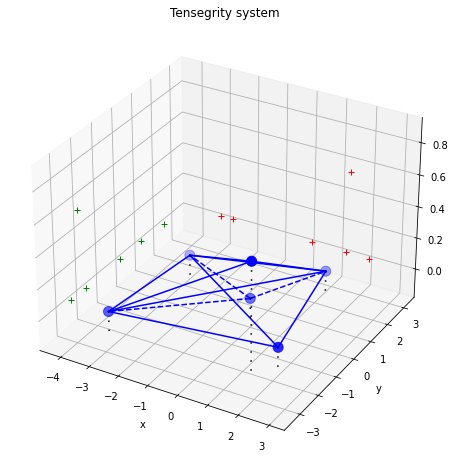

In [371]:
g, rho, c, k = 0.1, 0, 1, 0.1
consts = [g, rho, c, k]
N = 6

X0 = (np.random.rand(N, 3)).flatten()

cables = np.zeros((N, N))
bars = np.zeros((N, N))

cables[0, 1], cables[0, 2], cables[0, 3] = [7] * 3

bars[1, 2], bars[2, 3], bars[1, 4], bars[3, 4], bars[2, 4], bars[1, 5], bars[2, 5], bars[3, 5], bars[1,3] = [5] * 9

mu = 1000

ms = np.ones(N) * 1

def f(X):
    return Q(X, mu, cables, bars, ms, consts)

def df(X):
    return dQ(X, mu, cables, bars, ms, consts)

Y = BFGS(X0.flatten(), N, 0, cables, bars, 100, f, df, keep_limits=[False, False, True])